In [28]:
import operator
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import sys
import gc

import optuna
import logging
import pickle

from collections.abc import Callable

from pso_utils import *
from landscapes_utils import *

from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [29]:
SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100
gp_run_check = True # when true we can perform the run

In [30]:
def save_log(log, path='logs/log_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(log, lb_file)

def load_log(path='logs/log_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)

def save_hof(hof, path='logs/hof_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(hof, lb_file)

def load_hof(path='logs/hof_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)
    
def save_pop(pop, path='logs/hof_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(pop, lb_file)

def load_pop(path='logs/hof_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)

In [32]:
def func_dec(func):
    """Ensures that the output of an individual is a numpy array of dimension (SWARM_SIZE, 2)"""
    
    def new_func(swarm, velocity, global_best, personal_best, center_mass, dispersion):
        value = func(swarm, velocity, global_best, personal_best, center_mass, dispersion)
        if not isinstance(value, np.ndarray):
            return np.zeros((SWARM_SIZE, 2))
        else:
            try:
                value.shape[1] == 2
                return value
            except Exception:
                value = value.reshape(-1, 1)
                value = np.hstack((value, value))
                return value
    return new_func

In [74]:
def gen_rand(_):
    return np.random.uniform(np.zeros(2), np.ones(2), size=(SWARM_SIZE, 2))

In [ ]:
def shrink_or_uniform_mutation(individual, expr, pset, p_shrink=0.5):
    if random.random() < p_shrink:
        # Perform shrink mutation using gp.mutShrink
        individual, = gp.mutShrink(individual)
    else:
        # Perform uniform mutation using gp.mutUniform
        individual, = gp.mutUniform(individual, expr=expr, pset=pset)

    return individual,

# Expression generator function for creating new subtrees
def expr(min_=0, max_=2):
    return gp.genFull(pset=pset, min_=min_, max_=max_)


In [92]:
def GP_RUN(name=None):
    pset = gp.PrimitiveSet("MAIN", 6)
    # basic
    pset.addPrimitive(np.add, 2)
    pset.addPrimitive(np.negative, 1)
    pset.addPrimitive(np.subtract, 2)
    pset.addPrimitive(np.multiply, 2)
    # pset.addPrimitive(gen_rand, 1)

    # PRIMITIVES
    pset.addTerminal(np.pi)
    pset.addTerminal(1)
    # ephemeral constants
    pset.addEphemeralConstant("rand101", partial(random.uniform, 0, 5))
    pset.addEphemeralConstant("rand102", partial(random.uniform, 0, 5))
    pset.addEphemeralConstant("rand103", partial(random.uniform, 0, 5))

    # variables
    pset.renameArguments(ARG0="swarm")
    pset.renameArguments(ARG1="vel")
    pset.renameArguments(ARG2='gbest')
    pset.renameArguments(ARG3='pbest')
    pset.renameArguments(ARG4='center')
    pset.renameArguments(ARG5='dispersion')

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5) # 3<5
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    def GPFitness(individual):
        """Fitness of a gp individual"""
        
        problems = generate_problems(NUM_PROBLEMS)
        func = toolbox.compile(expr=individual)
        func = func_dec(func)
        vel_update = func
        S = SwarmGP(SWARM_SIZE, vel_update=vel_update)
        results = PSOResults(S, problems, NUM_ITERATIONS)
        value = float(np.median(results) + np.std(results))
        print(f'value = {value} -> ind = {individual}')
        return value,

    # def multi_mutate(individual):
    #     """Apply a random mutation type to the individual."""

    #     choose = random.randint(0, 2)
    #     if choos == 0:
    #         mutant, = 

        # mutation_functions = [toolbox.mutUniform, toolbox.mutShrink]
        # mutation = random.choice(mutation_functions)
        # mutant, = mutation(individual)  # Apply the chosen mutation
        # return mutant,


    toolbox.register("evaluate", GPFitness)
    toolbox.register("select", tools.selTournament, tournsize=3) # 1:1 replacement selection
    toolbox.register("mate", gp.cxOnePoint) # subtree crossover

    # mutations
    
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    # toolbox.register("mutate", gp.mutShrink)
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))

    def gp_run():
        random.seed(318)

        pop = toolbox.population(n=50)
        hof = tools.HallOfFame(5)

        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        stats_height = tools.Statistics(lambda ind: ind.height)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size, height=stats_height)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.2, ngen=20, stats=mstats,
                                    halloffame=hof, verbose=False)
        # doesn't recompute individuals that do not change
        if name is not None:
            save_hof(hof, f'logs/hof_{name}.pkl')
            save_pop(pop, f'logs/pop_{name}.pkl')
            save_log(log, f'logs/log_{name}.pkl')
            
        return pop, log, hof
    return gp_run()

In [ ]:
if gp_run_check:
    pop, log, hof = GP_RUN(name='shrink_unif_norand')

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


value = 152.06347593545814 -> ind = multiply(multiply(negative(1.5222510478769187), multiply(pbest, negative(swarm))), add(multiply(1, 1), multiply(add(1, 3.3427187929613495), vel)))
value = 137.14219615743525 -> ind = subtract(negative(negative(add(vel, dispersion))), add(multiply(pbest, subtract(vel, center)), add(center, 0.3404694188102153)))
value = 70.32659335343168 -> ind = multiply(negative(multiply(pbest, 3.141592653589793)), add(add(center, 1.3718674890667497), negative(center)))
value = 3.735530103139313 -> ind = negative(add(add(add(dispersion, 1), add(center, swarm)), subtract(subtract(swarm, dispersion), add(dispersion, 1))))
value = 157.72479985262615 -> ind = multiply(add(negative(2.16184469960932), add(swarm, dispersion)), add(subtract(1, 1), multiply(dispersion, pbest)))
value = 48.08900298862337 -> ind = subtract(add(negative(center), negative(pbest)), multiply(add(1, pbest), add(3.083799426744708, 3.141592653589793)))
value = 3.7587313917108705 -> ind = subtract(add(

# Results

In [91]:
# hof = load_hof()

for i in range(len(hof)):
    print(f'height = {hof[i].height} and len = {len(hof[i])} -> {hof[i]}')

height = 11 and len = 32 -> negative(negative(subtract(negative(add(add(center, add(dispersion, swarm)), subtract(add(add(gbest, add(add(subtract(swarm, swarm), swarm), negative(4.5640609907865315))), swarm), gbest))), negative(subtract(multiply(1, dispersion), add(swarm, 3.028784002249096))))))
height = 7 and len = 12 -> negative(negative(negative(add(add(1, add(add(swarm, swarm), swarm)), swarm))))
height = 8 and len = 14 -> negative(negative(negative(add(add(1, add(add(subtract(swarm, swarm), swarm), swarm)), swarm))))
height = 6 and len = 13 -> negative(negative(subtract(negative(swarm), negative(subtract(multiply(1, dispersion), add(swarm, 3.028784002249096))))))
height = 6 and len = 10 -> negative(negative(negative(add(add(add(1, swarm), swarm), swarm))))


In [37]:
# first shrink attempt with len = 3 and len = 6 -> negative(multiply(swarm, subtract(3.141592653589793, 1)))

In [87]:
print(log)

   	      	                    fitness                    	                     height                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg 	gen	max	min	nevals	std    	avg   	gen	max 	min	nevals	std    
0  	50    	78.8964	0  	165.978	4.28174	50    	45.3548	8.06	0  	10 	6  	50    	1.22327	244.18	0  	1054	19 	50    	292.648
1  	30    	42.6163	1  	139.062	3.8496 	30    	35.7389	8.18	1  	11 	6  	30    	1.3666 	219.54	1  	1056	19 	30    	294.215
2  	33    	26.8392	2  	147.622	3.61915	33    	37.932 	8   	2  	11 	5  	33    	1.66132	200.94	2  	1056	18 	33    	330.082
3  	32    	18.0019	3  	163.357	3.50188	32    	37.9094	7.92	3  	12 	2  	32    	2.11509	266.54	3  	1055	3  	32    	403.785
4  	29    	9.98908	4  	141.207	3.41632	29    	26.7442	8.16	4  	12 	5  	29    	1.71301

# plot

In [88]:
log_uni = load_log()
# log_shrink_0.2 = load_log('')

In [89]:
def plot_log(log):
    gen = log.select("gen")
    fit_mins = log.chapters["fitness"].select("min")
    size_avgs = log.chapters["height"].select("avg")

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    ax1.axhline(y = 2.21, color = 'black', linestyle = ':')
    ax1.axhline(y = 4.66, color = 'black', linestyle = ':')
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, size_avgs, "r-", label="Average Height")
    ax2.set_ylabel("Height", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    return plt

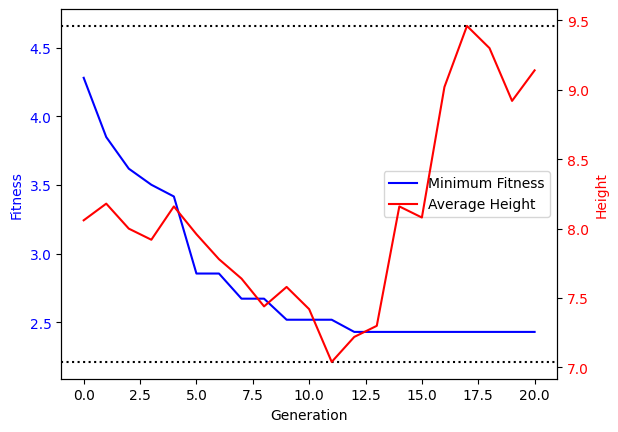

In [90]:
# plt = plot(log)
plt2 = plot_log(log)
plt.show()

In [55]:
fig, axs = plt.subplot(2)
axs[0] = plot_log(log_uni)

ValueError: Single argument to subplot must be a three-digit integer, not 2

<Figure size 640x480 with 0 Axes>

In [67]:
log = load_log('logs/log_shrink.pkl')

<module 'matplotlib.pyplot' from 'c:\\Users\\andre\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

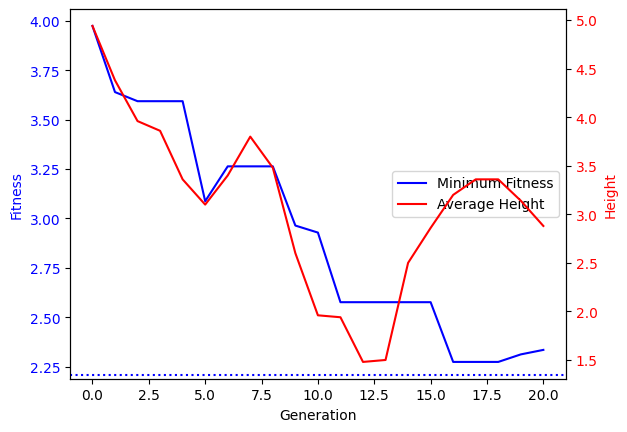

In [48]:
plot_log(log)